#### Check out the DECam sky data

In [21]:
import numpy as np 
# -- astropy -- 
import astropy.time
import astropy.coordinates
import astropy.units as u 
from astropy.io import fits
from astropy import table as aTable
# -- feasibgs --
from feasibgs import util as UT
# -- others -- 
import speclite
import specsim.simulator

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
fdecam = fits.open(''.join([UT.dat_dir(), 'decalsobs-zpt-dr3-allv2.fits']))

In [5]:
decam = fdecam[1].data

In [7]:
decam.names

['FILENAME',
 'EXPNUM',
 'EXPTIME',
 'ZD',
 'AIRMASS',
 'FILTER',
 'SEEING',
 'TRANSP',
 'RA',
 'DEC',
 'DATE',
 'CCDNUM',
 'CCDNAME',
 'CCDZPT',
 'SKYBR',
 'SKYSIG',
 'DEPTH',
 'SUNSEP',
 'SUNALT',
 'MOONSEP',
 'MOONPHASE',
 'MOONUP']

In [11]:
keep = (decam['AIRMASS'] != 0.0)
print("%i of %i have airmass != 0." % (np.sum(keep), decam['AIRMASS'].shape[1]))

26561 of 27491 have airmass != 0.


In [29]:
time = astropy.time.Time(decam['DATE'], format='jd')
location = astropy.coordinates.EarthLocation.from_geodetic(
    lat='-30d10m10.78s', lon='-70d48m23.49s', height=2241.4*u.m)

moon_position = astropy.coordinates.get_moon(time, location)
moon_ra = moon_position.ra.value
moon_dec = moon_position.dec.value
moon_position_altaz = moon_position.transform_to(astropy.coordinates.AltAz(obstime=time, location=location))
moon_alt = moon_position_altaz.alt.value
moon_az = moon_position_altaz.az.value

def separation(ra1, dec1, ra2, dec2):
    pi2 = np.radians(90)
    alpha = np.cos(np.radians(ra1)-np.radians(ra2))
    first = np.cos(pi2-np.radians(dec1))*np.cos(pi2-np.radians(dec2))
    second = np.sin(pi2-np.radians(dec1))*np.sin(pi2-np.radians(dec2))*alpha
    return np.arccos(first+second)*180/np.pi

separation_angle = separation(decam['RA'], decam['DEC'], ra2=moon_ra, dec2=moon_dec)

(0.0, 1.0)

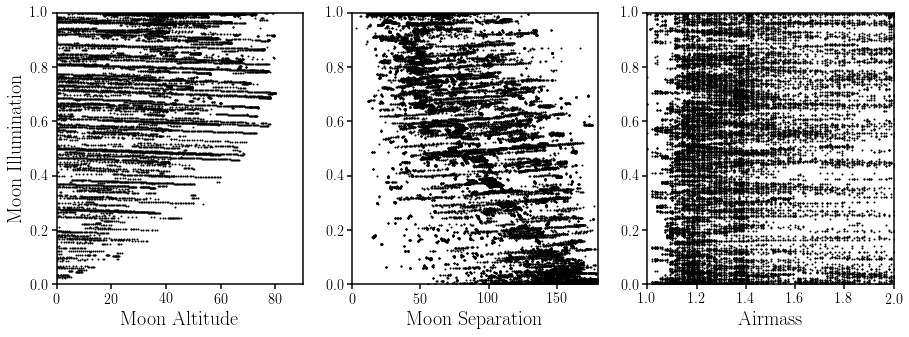

In [14]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(moon_alt, decam['MOONPHASE'], c='k', s=1)
#sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(decam['MOONSEP'], decam['MOONPHASE'], c='k', s=1)
#sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(decam['AIRMASS'], decam['MOONPHASE'], c='k', s=1)
#sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='k', s=1)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

In [16]:
boss_blue = aTable.Table.read(''.join([UT.dat_dir(), 'sky/', 'Bright_BOSS_Sky_blue.fits']))

(0.0, 1.0)

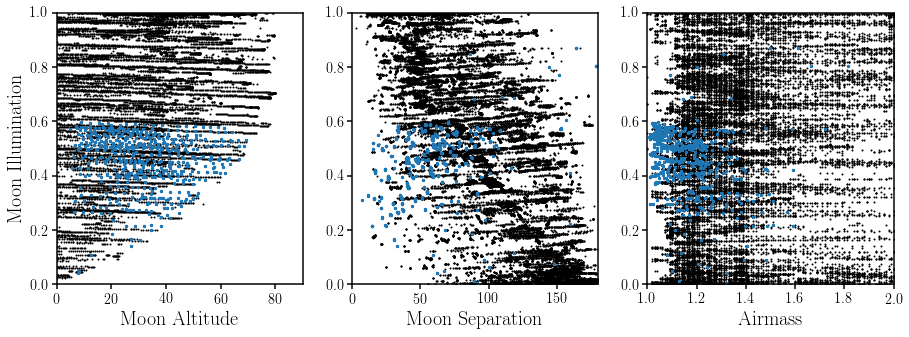

In [18]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(moon_alt, decam['MOONPHASE'], c='k', s=1)
sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='C0', s=5)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(decam['MOONSEP'], decam['MOONPHASE'], c='k', s=1)
sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='C0', s=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(decam['AIRMASS'], decam['MOONPHASE'], c='k', s=1)
sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='C0', s=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])

In [20]:
sky_model = specsim.simulator.Simulator('desi').atmosphere

In [41]:
cut_g = (decam['FILTER'] == 'g') & (moon_alt > 10.) & (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3) & keep
cut_r = (decam['FILTER'] == 'r') & (moon_alt > 10.) & (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3) & keep
cut_z = (decam['FILTER'] == 'z') & (moon_alt > 10.) & (decam['TRANSP'] > .75) & (decam['TRANSP'] < 1.3) & keep

def get_KSsky(band):  
    filter_response = speclite.filters.load_filter('decam2014-{}'.format(band))
    
    if band == 'g': cut = cut_g 
    elif band == 'r': cut = cut_r
    elif band == 'z': cut = cut_z
    nrows = np.sum(cut)
    sky_brightness = np.empty(nrows, dtype=float)

    for i in range(nrows):
        sky_model.airmass = decam['AIRMASS'][cut][i]
        sky_model.moon.moon_phase = np.arccos(2 * decam['MOONPHASE'][cut][i] - 1.) / np.pi
        sky_model.moon.moon_zenith = (90. - moon_alt[cut][i]) * u.deg
        sky_model.moon.separation_angle = separation_angle[cut][i] * u.deg
        scattered_moon = (sky_model.surface_brightness * u.arcsec ** 2).to(u.erg / (u.Angstrom * u.cm ** 2 * u.s))
        moon_flux, sky_wlen = filter_response.pad_spectrum(scattered_moon, sky_model._wavelength)
        sky_brightness[i] = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return sky_brightness

def flux_to_mag(flux):
    return 22.5 - 2.5*np.log10(flux*10**9)

In [51]:
sky_g = get_KSsky('g')
sky_r = get_KSsky('r')
sky_z = get_KSsky('z')

(16, 22)

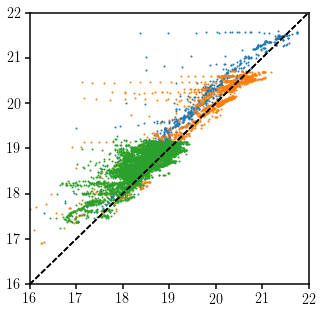

In [53]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(decam['SKYBR'][cut_g], flux_to_mag(sky_g), s=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlim([16, 22])
sub.set_ylim([16, 22])

sub.scatter(decam['SKYBR'][cut_r], flux_to_mag(sky_r), s=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlim([16, 22])
sub.set_ylim([16, 22])

sub.scatter(decam['SKYBR'][cut_z], flux_to_mag(sky_z), s=1)
sub.plot([16, 22], [16, 22], c='k', ls='--')
sub.set_xlim([16, 22])
sub.set_ylim([16, 22])

(0.0, 1.0)

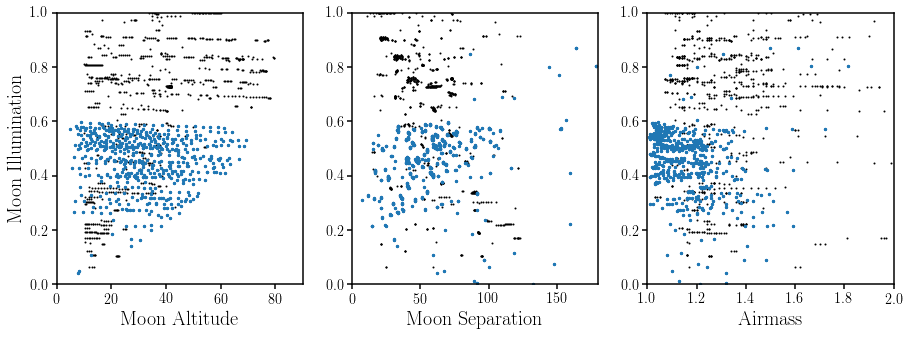

In [47]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(moon_alt[cut_g], decam['MOONPHASE'][cut_g], c='k', s=1)
sub.scatter(boss_blue['MOON_ALT'], boss_blue['MOON_ILL'], c='C0', s=5)
sub.set_xlabel('Moon Altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylabel('Moon Illumination', fontsize=20)
sub.set_ylim([0., 1.])
sub = fig.add_subplot(132)
sub.scatter(decam['MOONSEP'][cut_g], decam['MOONPHASE'][cut_g], c='k', s=1)
sub.scatter(boss_blue['MOON_SEP'], boss_blue['MOON_ILL'], c='C0', s=5)
sub.set_xlabel('Moon Separation', fontsize=20)
sub.set_xlim([0., 180.])
sub.set_ylim([0., 1.])
sub = fig.add_subplot(133)
sub.scatter(decam['AIRMASS'][cut_g], decam['MOONPHASE'][cut_g], c='k', s=1)
sub.scatter(boss_blue['AIRMASS'], boss_blue['MOON_ILL'], c='C0', s=5)
sub.set_xlabel('Airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylim([0., 1.])